In [1]:
# processing
import pymysql.cursors
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scikitplot as skplt
from pandas import ExcelWriter
scaler = StandardScaler()
label = LabelEncoder()
import warnings
warnings.filterwarnings('ignore')
# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", color_codes=True)
%matplotlib inline
# vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.externals.six import StringIO
import pydot
# model
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score, train_test_split, KFold 
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, f1_score, confusion_matrix, precision_score, recall_score, classification_report
# classificators
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.linear_model import SGDClassifier 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals import joblib
import IDF
from sklearn.calibration import CalibratedClassifierCV
import lightgbm
from sklearn import tree
from sklearn.externals.six import StringIO
import pydot

In [2]:
# Подключиться к базе данных
def con():
    conn = pymysql.connect(
        host='10.100.0.100',
        port=33062,
        user='i.serov',
        password='7*&y9EkL',
        db='mysql')
    return conn

In [3]:
%%time
df = pd.read_sql('''
select c.id as first_credit_id

  , if(curdate()>date(c.date_requested)+ interval least(c.credit_count_days , 31) + 60 day,1,0) as first_matured60dpd_ind
  , if(curdate()>date(c.date_requested)+ interval least(c.credit_count_days , 31) + 30 day,1,0) as first_matured30dpd_ind
  , if(curdate()>date(c.date_requested)+ interval least(c.credit_count_days , 31) + 15 day,1,0) as first_matured15dpd_ind
  , if(curdate()>date(c.date_requested)+ interval least(c.credit_count_days , 31) + 3 day,1,0) as first_matured3dpd_ind
  
    ,  (SELECT IF(((COUNT(`credit_payment`.`id`) > 0) OR (CURDATE() < (c.date_received +  interval (least( c.credit_count_days  , 61 ) ) day + INTERVAL 31 DAY))), 0, 1)
       FROM moneyman_es.`credit_payment`
       WHERE ((`credit_payment`.`credit_id` = `c`.`id`)
        AND (`credit_payment`.`payment_date` < (c.date_received +  interval (least( c.credit_count_days  , 31 ) ) day + INTERVAL 61 DAY)))) AS NPL60
        
  ,  (SELECT IF(((COUNT(`credit_payment`.`id`) > 0) OR (CURDATE() < (c.date_received +  interval (least( c.credit_count_days  , 31 ) ) day + INTERVAL 31 DAY))), 0, 1)
       FROM moneyman_es.`credit_payment`
       WHERE ((`credit_payment`.`credit_id` = `c`.`id`)
        AND (`credit_payment`.`payment_date` < (c.date_received +  interval (least( c.credit_count_days  , 31 ) ) day + INTERVAL 31 DAY)))) AS NPL30
        
   ,  (SELECT IF(((COUNT(`credit_payment`.`id`) > 0) OR (CURDATE() < (c.date_received +  interval (least( c.credit_count_days  , 31 ) ) day + INTERVAL 16 DAY))), 0, 1)
       FROM moneyman_es.`credit_payment`
       WHERE ((`credit_payment`.`credit_id` = `c`.`id`)
        AND (`credit_payment`.`payment_date` < (c.date_received +  interval (least( c.credit_count_days  , 31 ) ) day + INTERVAL 16 DAY)))) AS NPL15  
  
  ,  (SELECT IF(((COUNT(`credit_payment`.`id`) > 0) OR (CURDATE() < (c.date_received +  interval (least( c.credit_count_days  , 31 ) ) day + INTERVAL 16 DAY))), 0, 1)
       FROM moneyman_es.`credit_payment`
       WHERE ((`credit_payment`.`credit_id` = `c`.`id`)
        AND (`credit_payment`.`payment_date` < (c.date_received +  interval (least( c.credit_count_days  , 31 ) ) day + INTERVAL 4 DAY)))) AS NPL3
  
  , if(c.status in ('active', 'completed', 'expired'),1,0) as first_issued_ind
  , if(c.status ='completed',1,0) as first_completed_ind
  , (select timestampdiff(year, pdin.birthday, c.date_requested) from moneyman_es.personal_data pdin join moneyman_es.borrower bin on bin.personal_data_id = pdin.id where bin.id = c.borrower_id) as bor_age
, (select pdin.sex from moneyman_es.personal_data pdin join moneyman_es.borrower bin on bin.personal_data_id = pdin.id where bin.id = c.borrower_id) as bor_gender
  , c.credit_count_days as first_count_days
  , c.initial_amount as first_amount
  , case when pi.credit_id is not null and c.credit_promo_id is not null then 'solcredito_0'
   when pi.credit_id is not null and c.credit_promo_id is null then 'solcredito_not_0'
   when c.finance_type = 'pdl' and not (pi.credit_id is not null and c.credit_promo_id is not null) and not (pi.credit_id is not null and c.credit_promo_id is null) then 'Other PDL'
  else c.finance_type end as first_loan_bucket
  , timestampdiff(day, c.date_received, c.date_repaid)  as first_loan_util_days
  , (select sain.Scorecard_Points from moneyman_es.scoring_aggregated sain where c.id = sain.Credit_ID order by id desc limit 1) as first_appl_sc30_points
  , sp.*
  , pd.maritalStatus
  , pd.habitation
from moneyman_es.credit c
join moneyman_es.borrower b on c.borrower_id = b.id
join moneyman_es.personal_data pd ON pd.id = b.personal_data_id
left join moneyman_es.partner_integration pi on pi.credit_id = c.id
left join moneyman_es.scoring_params sp on sp.credit_id = c.id
where c.credit_number=1 and c.status in ('active', 'completed', 'expired') /* and c.status = 'completed' and c.id=1333329 */
 and  pi.credit_id is not null and c.credit_promo_id is not null 
   ;''', con=con())
df.fillna(-1, inplace=True)
df1 = df.copy()

Wall time: 1.32 s


In [93]:
#X.dtypes[(X.dtypes!=object) & (X.dtypes!=int) & (X.dtypes!=float)][50:100]
#X.dtypes[X.dtypes==object]
#df.last_account_proof_uploaded_date.value_counts()
#df.dtypes[df.dtypes==object]
#df.NPL30.value_counts()

# Preprocessing

#### Df preprocessing

In [4]:
df.drop(['credit_id', 'id', 'last_account_proof_uploaded_date', 'adr_postal_code', 'create_date',
         'appl_pmt_accnt_bank_CD', 'iov_device_os','credit_date_requested','first_completed_ind',
         'initiator',  'first_loan_bucket', 'user_account_email', 'first_loan_util_days',
         'adr_postal_code','bor_loan_purpose','appl_time_day_hour_5d_3h','first_credit_id',
         'last_dni_uploaded_date','last_account_proof_uploaded_date'
         ], axis=1, inplace=True)

In [5]:
cat_vars = ['habitation', 'personal_data_marital_status', 'maritalStatus',  'address_real_address_city',
           'deyede_integration_data_segxxx', 'iov_device_type','cluster_4digit_post_CD','bor_work_employment',
            'bor_work_industry','deyede_integration_data_indfia','bor_living_place_type'
           ]
for i in cat_vars:
    df[i] = label.fit_transform(df[i].astype(str))

# Tree NPL15

In [6]:
y = df[df.first_matured15dpd_ind==1].NPL15
X = df[df.first_matured15dpd_ind==1].drop(['NPL15','NPL60','NPL30','NPL3',
             'first_matured60dpd_ind',
             'first_matured30dpd_ind',
             'first_matured15dpd_ind',
             'first_matured3dpd_ind'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=1)

In [7]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth = 5, random_state=1, min_samples_leaf=10
                             #, class_weight = {0: 2, 1: 1}
                            ).fit(X_train, y_train)

ROC_AUC:   0.5878378378378379
Gini:      0.17567567567567588
F1_score:  0.08849557522123894
Log_loss:  6.687160020365111


Classification_report: 
              precision    recall  f1-score   support

          0       0.98      0.82      0.89       518
          1       0.05      0.36      0.09        14

avg / total       0.95      0.81      0.87       532



Weight,Feature
0.1777,inst_balance_curr
0.1071,first_appl_sc30_points
0.1026,instantor_agg_negative_total_withdraw_and_others_amount_M3
0.0777,badexcug_tot_unpaid_amnt_all_ma_not_telco
0.0760,instantor_agg_negative_total_other_lenders_amount_M2
0.0690,instantor_agg_negative_total_microlenders_count_M1
0.0589,inst_appl_sum_of_positive_transactions_L1M
0.0529,instantor_agg_negative_total_supermarket_count_m2
0.0495,work_employment_id
0.0400,personal_data_payments_loans


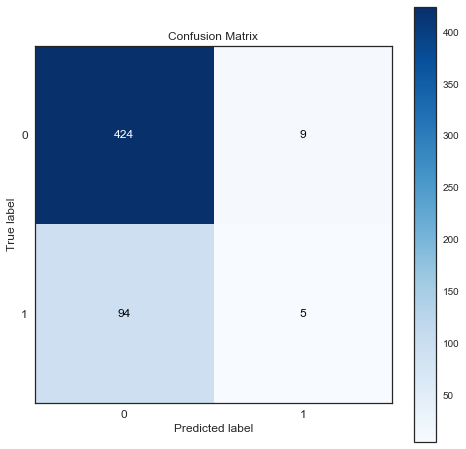

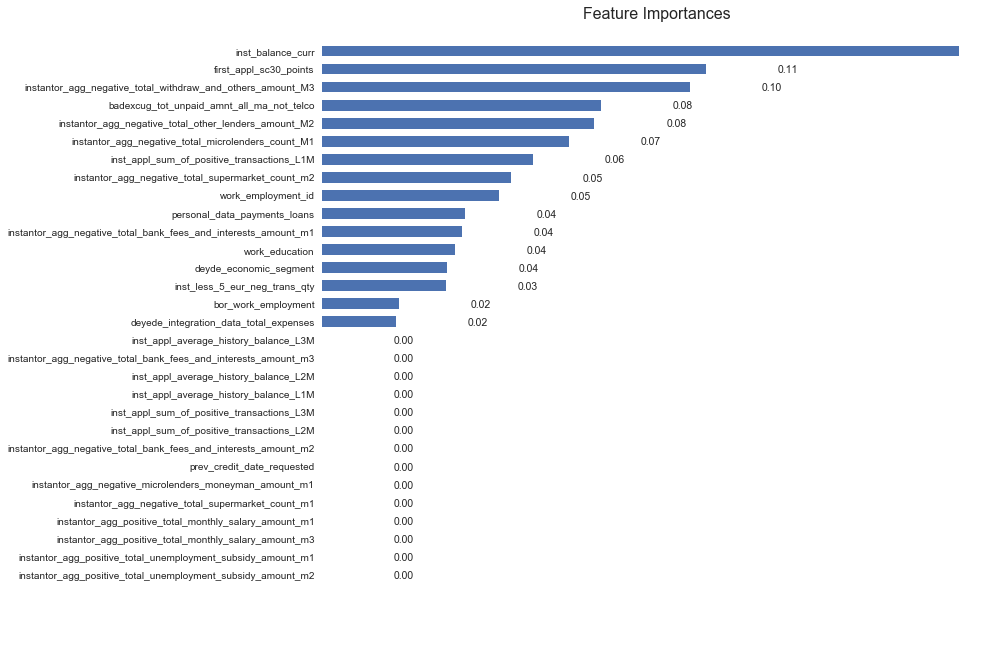

In [10]:
IDF.plot_score(clf, X_test, y_test,cut_off=0.5)

In [11]:
tree.export_graphviz(clf, out_file='tree_ES_1.dot', feature_names = X.columns, proportion =True, impurity =True, filled=True, class_names = True) 

# TREE NPL3

In [143]:
y = df[df.first_matured3dpd_ind==1].NPL3
X = df[df.first_matured3dpd_ind==1].drop(['NPL15','NPL60','NPL30','NPL3',
             'first_matured60dpd_ind',
             'first_matured30dpd_ind',
             'first_matured15dpd_ind',
             'first_matured3dpd_ind'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=1)

In [144]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth = 5, random_state=1, min_samples_leaf=10
                             #, class_weight = {0: 2, 1: 1}
                            ).fit(X_train, y_train)

ROC_AUC:   0.5955591147350029
Gini:      0.19111822947000578
F1_score:  0.27135678391959805
Log_loss:  8.438966571324329


Classification_report: 
              precision    recall  f1-score   support

          0       0.91      0.79      0.85       505
          1       0.21      0.40      0.27        68

avg / total       0.82      0.75      0.78       573



Weight,Feature
0.2352,inst_Balance_Avg_L30d
0.1759,inst_balance_curr
0.1176,first_appl_sc30_points
0.0814,incofisa_summary_type_m_number_alerts
0.0727,badexcug_tot_unpaid_amnt_all_ma_not_telco
0.0696,instantor_agg_negative_total_supermarket_count_m2
0.0661,dni_uploaded_flag
0.0544,instantor_agg_negative_microlenders_nbq_amount_M2
0.0428,personal_data_payments_loans
0.0382,bor_age


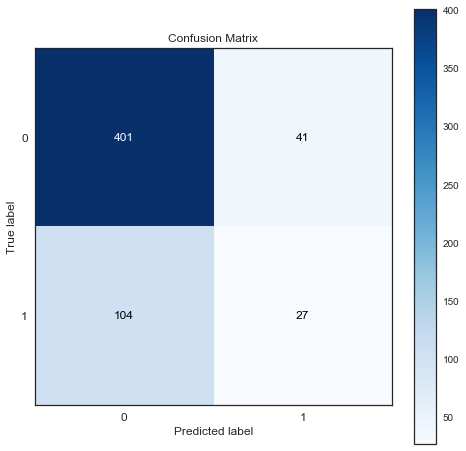

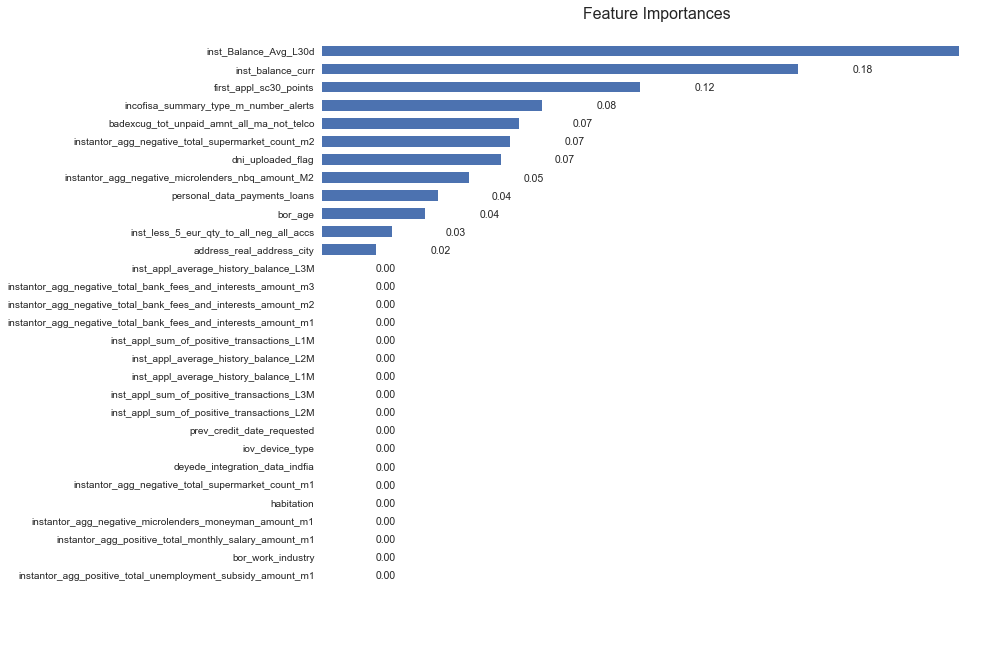

In [145]:
IDF.plot_score(clf, X_test, y_test,cut_off=0.4)

In [ ]:
tree.export_graphviz(clf, out_file='tree_ES_1.dot', feature_names = X.columns, class_names = True) 

# TREE NPL30

In [12]:
y = df[df.first_matured30dpd_ind==1].NPL30
X = df[df.first_matured30dpd_ind==1].drop(['NPL15','NPL60','NPL30','NPL3',
             'first_matured60dpd_ind',
             'first_matured30dpd_ind',
             'first_matured15dpd_ind',
             'first_matured3dpd_ind'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=1)

In [13]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth = 5, random_state=1, min_samples_leaf=10
                             #, class_weight = {0: 2, 1: 1}
                            ).fit(X_train, y_train)

ROC_AUC:   0.5988892572944297
Gini:      0.1977785145888593
F1_score:  0.2900763358778625
Log_loss:  6.193782204609604


Classification_report: 
              precision    recall  f1-score   support

          0       0.90      0.87      0.89       416
          1       0.26      0.33      0.29        58

avg / total       0.82      0.80      0.81       474



Weight,Feature
0.1441,instantor_agg_negative_total_microlenders_amount_M1
0.1432,inst_balance_curr
0.1383,deyede_integration_data_total_expenses
0.1037,first_appl_sc30_points
0.0646,appl_direct_debiting_flag
0.0637,deyede_integration_data_segxxx
0.0483,instantor_agg_negative_total_bank_transfers_pay_out_amount_M1
0.0472,inst_sum_of_negative_transactions_L2M
0.0439,badexcug_tot_unpaid_amnt_all_ma_not_telco
0.0437,maritalStatus


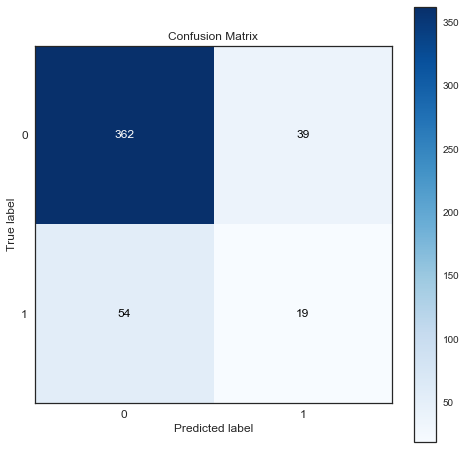

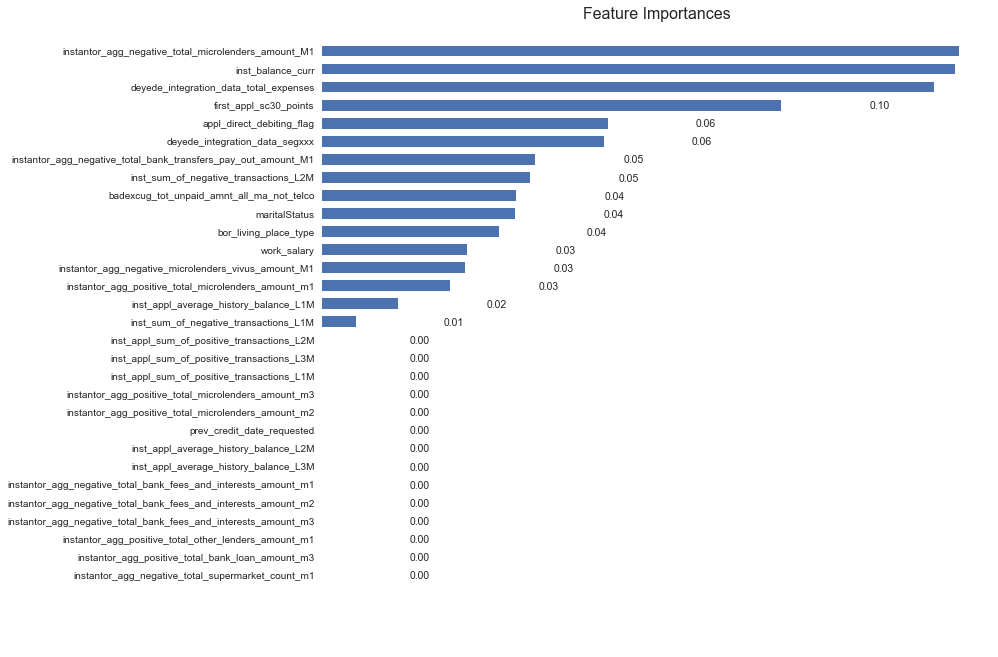

In [14]:
IDF.plot_score(clf, X_test, y_test, cut_off=0.4)

In [15]:
tree.export_graphviz(clf, out_file='tree_ES_1.dot', feature_names = X.columns, proportion =True, impurity =True, filled=True, class_names = True) 

# TREE NPL60

In [149]:
y = df[df.first_matured60dpd_ind==1].NPL60
X = df[df.first_matured60dpd_ind==1].drop(['NPL15','NPL60','NPL30','NPL3',
             'first_matured60dpd_ind',
             'first_matured30dpd_ind',
             'first_matured15dpd_ind',
             'first_matured3dpd_ind'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=1)

In [150]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth = 5, random_state=1, min_samples_leaf=10
                             #, class_weight = {0: 2, 1: 1}
                            ).fit(X_train, y_train)

ROC_AUC:   0.5877884187982382
Gini:      0.17557683759647635
F1_score:  0.3181818181818182
Log_loss:  5.533003938691152


Classification_report: 
              precision    recall  f1-score   support

          0       0.85      0.89      0.87       339
          1       0.36      0.29      0.32        73

avg / total       0.76      0.78      0.77       412



Weight,Feature
0.2886,first_appl_sc30_points
0.1142,inst_number_of_negative_transactions_L1M
0.0944,inst_balance_curr
0.0736,inst_less_5_eur_neg_trans_qty
0.0652,inst_appl_sum_of_positive_transactions_L2M
0.0544,inst_appl_average_history_balance_L1M
0.0512,instantor_agg_negative_total_withdraw_and_others_amount_M2
0.0494,appl_direct_debiting_flag
0.0459,deyde_economic_segment
0.0382,incofisa_summary_type_m_number_alerts


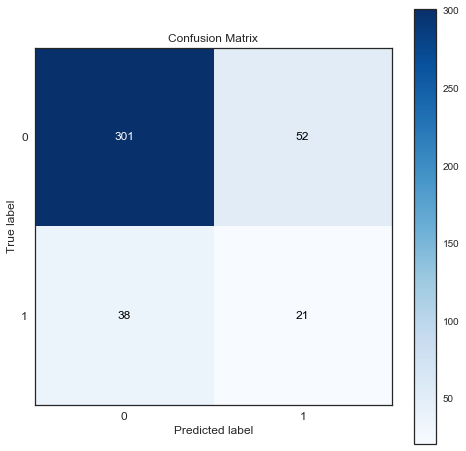

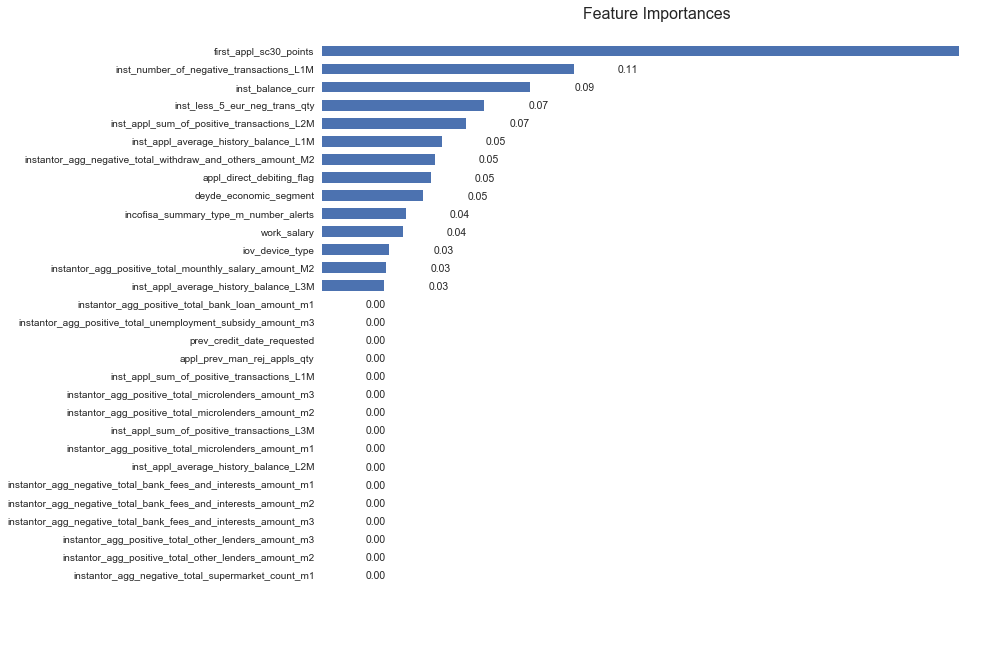

In [151]:
IDF.plot_score(clf, X_test, y_test,cut_off=0.4)

In [16]:
tree.export_graphviz(clf, out_file='tree_ES_1.dot', feature_names = X.columns, class_names = True)

# Score and Graphs

ROC_AUC:   0.6294715447154471
Gini:      0.25894308943089417
F1_score:  0.2368421052631579
Log_loss:  7.206547631542623


Classification_report: 
              precision    recall  f1-score   support

          0       0.95      0.81      0.87       492
          1       0.16      0.45      0.24        40

avg / total       0.89      0.78      0.82       532



Weight,Feature
0.0708 ± 0.1462,first_appl_sc30_points
0.0602 ± 0.1140,work_salary
0.0598 ± 0.1384,personal_data_payments_loans
0.0587 ± 0.1520,address_real_address_city
0.0391 ± 0.1314,deyde_economic_segment
0.0352 ± 0.1168,deyede_integration_data_total_expenses
0.0227 ± 0.0833,inst_balance_curr
0.0208 ± 0.0678,bor_age
0.0186 ± 0.0764,inst_less_5_eur_neg_trans_qty
0.0176 ± 0.0634,deyede_integration_data_indfia


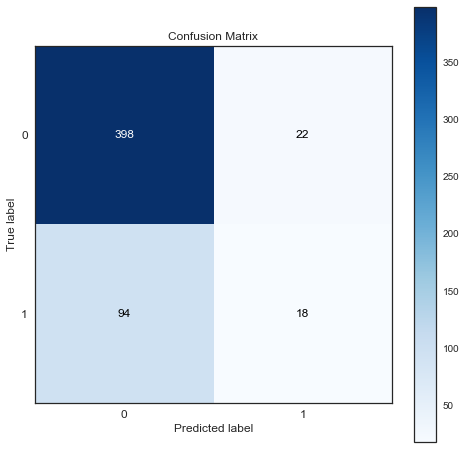

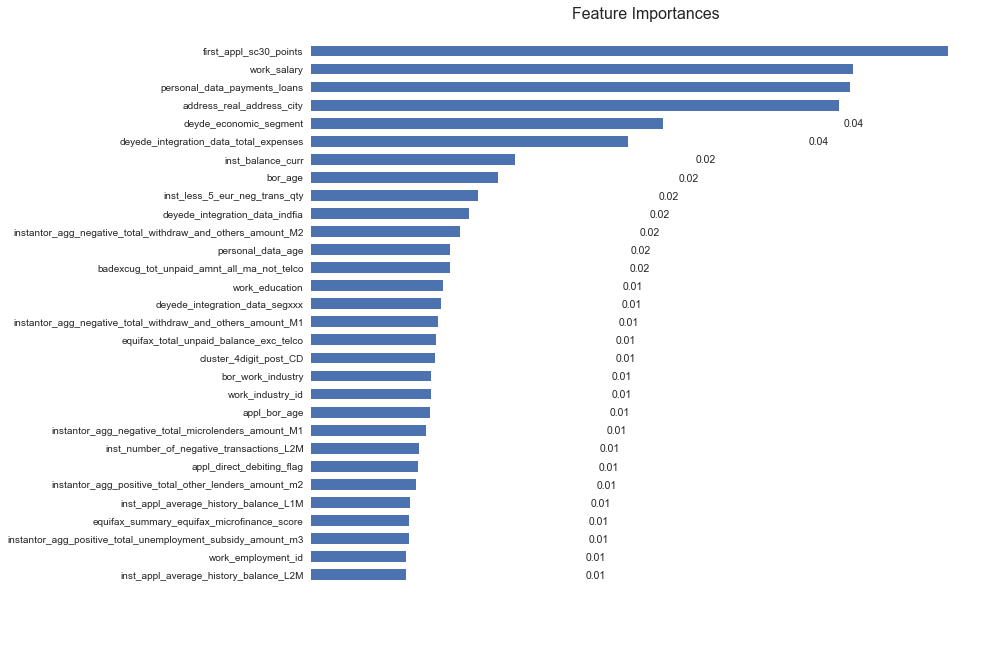

In [101]:
#
IDF.plot_score(clf2, X_test, y_test, cut_off=0.4)

ROC_AUC:   0.6707247709281307
Gini:      0.3414495418562613
F1_score:  0.409288824383164
Log_loss:  8.25988285959708


Classification_report: 
              precision    recall  f1-score   support

          0       0.91      0.81      0.85      1464
          1       0.33      0.54      0.41       263

avg / total       0.82      0.76      0.79      1727



Weight,Feature
0.0432 ± 0.2100,microlenders_amount_M1
0.0294 ± 0.1655,withdraw_and_others_amount_M1
0.0286 ± 0.1661,microlenders_amount_M2
0.0192 ± 0.1279,amount
0.0185 ± 0.0981,age
0.0182 ± 0.1271,supermarket_amount_M1
0.0179 ± 0.1107,insurance_amount_M3
0.0176 ± 0.1293,supermarket_amount_M3
0.0165 ± 0.1093,cash_deposit_and_others_amount_M3
0.0157 ± 0.1348,bank_transfer_receipt_amount_M2


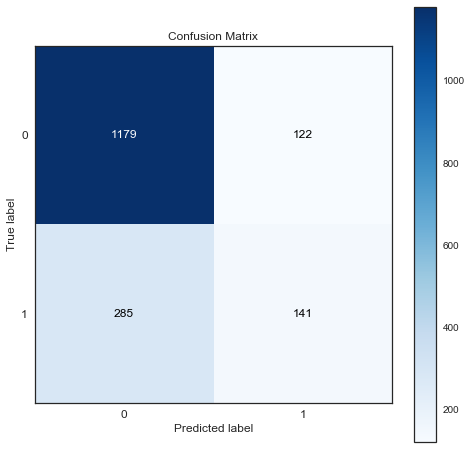

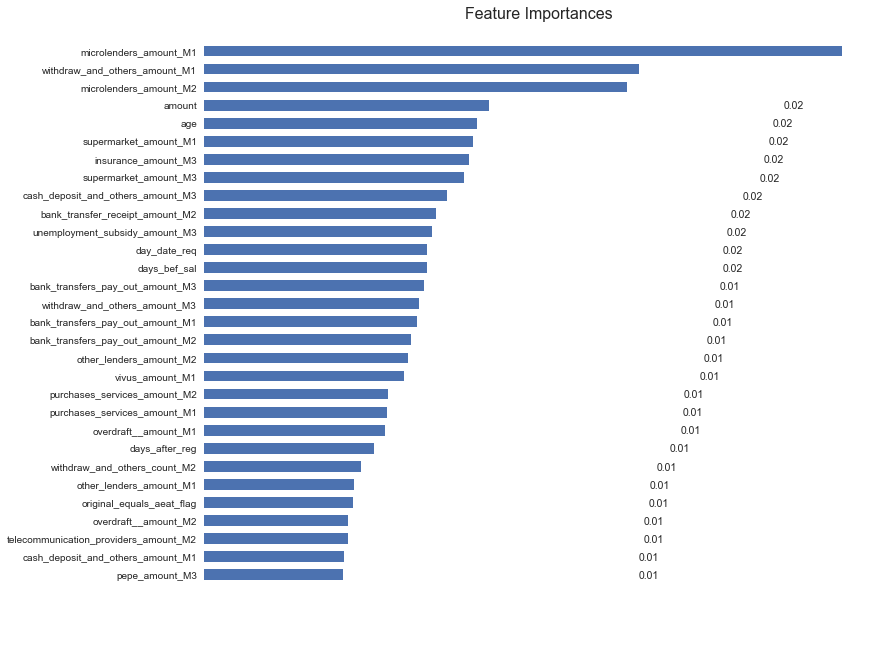

In [45]:
#
IDF.plot_score(gs.best_estimator_, X_test, y_test, cut_off=0.4)

In [89]:
joblib.dump(clf3, 'ES_col_30.pkl');

In [771]:
qq = X.copy()
qq['preds_proba'] = clf3.predict_proba(X)[:,1]
qq['preds'] = clf3.predict(X)
qq['credit_id'] = ids
qq['real'] = y
qq = qq[['credit_id', 'preds', 'preds_proba', 'real']]

In [772]:
r = pd.concat([qq, X], axis=1)

In [809]:
writer = pd.ExcelWriter('COL_ %s - %s.xlsx' % (min_date, max_date))
for_export.to_excel(writer,'FOR_COLLECTION', index=False)
writer.save()